## Preliminary step: import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import minmax_scale
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from utils import *
from cv2 import rectangle

plt.rcParams['figure.dpi'] = 300

## Step 1

First step in training an R-CNN is to obtain class examples per individual which can be used for training a CNN which will be used later to extract features from region proposals. I have constructed three helper function that generates randomly sized images from three classes: background, circle and square. The image dimensions are random to realistically imitate region proposals from an image containing several objects.

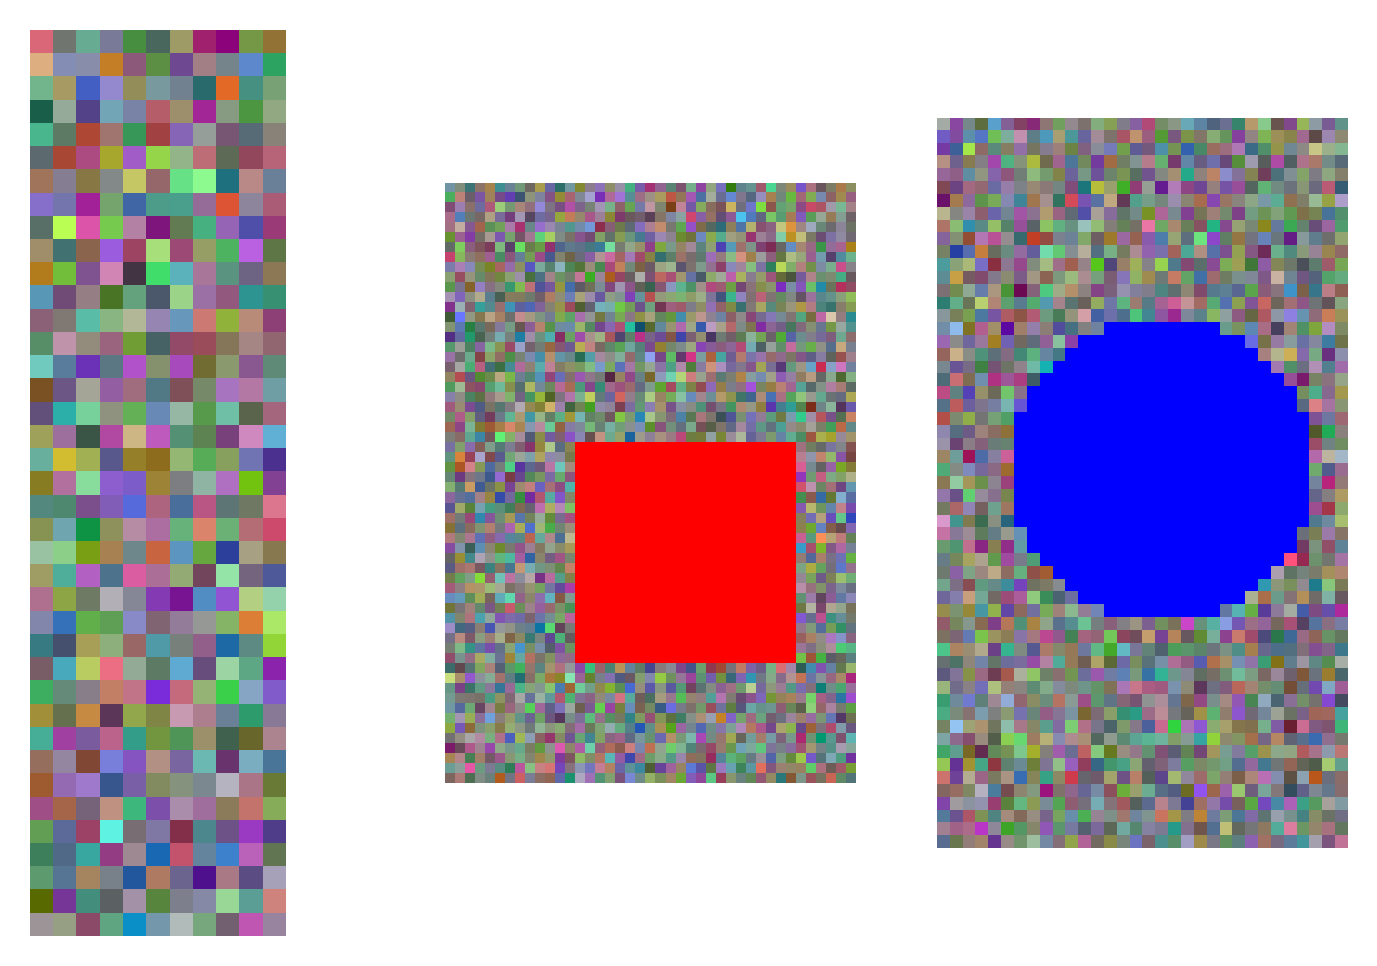

In [2]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(generate_background()); axes[0].axis('off')
axes[1].imshow(generate_square()); axes[1].axis('off')
axes[2].imshow(generate_circle()); axes[2].axis('off')
plt.show()

To be used as input to a CNN, these images needs to be reshaped to a predefined size which results in warped class examples as shown in the next figure.

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-10 13:36:58.283428: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-10 13:36:58.284041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


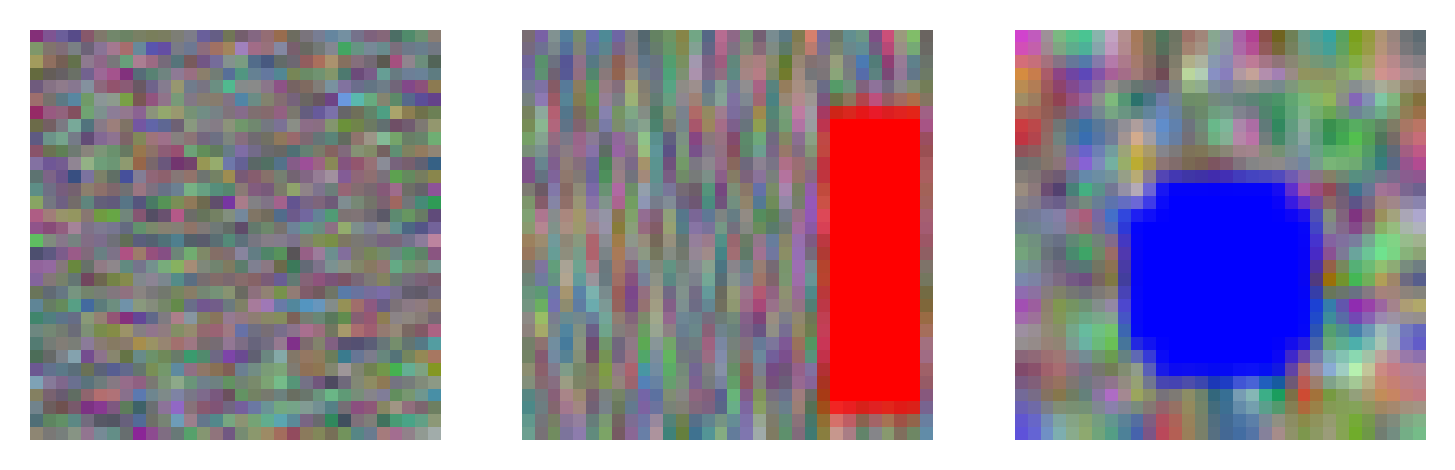

In [3]:
size = (32, 32)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(tf.image.resize(generate_background(), size)); axes[0].axis('off')
axes[1].imshow(tf.image.resize(generate_square(), size)); axes[1].axis('off')
axes[2].imshow(tf.image.resize(generate_circle(), size)); axes[2].axis('off')
plt.show()

## Step 2
Now we construct a complete training set with *n* examples of each class.

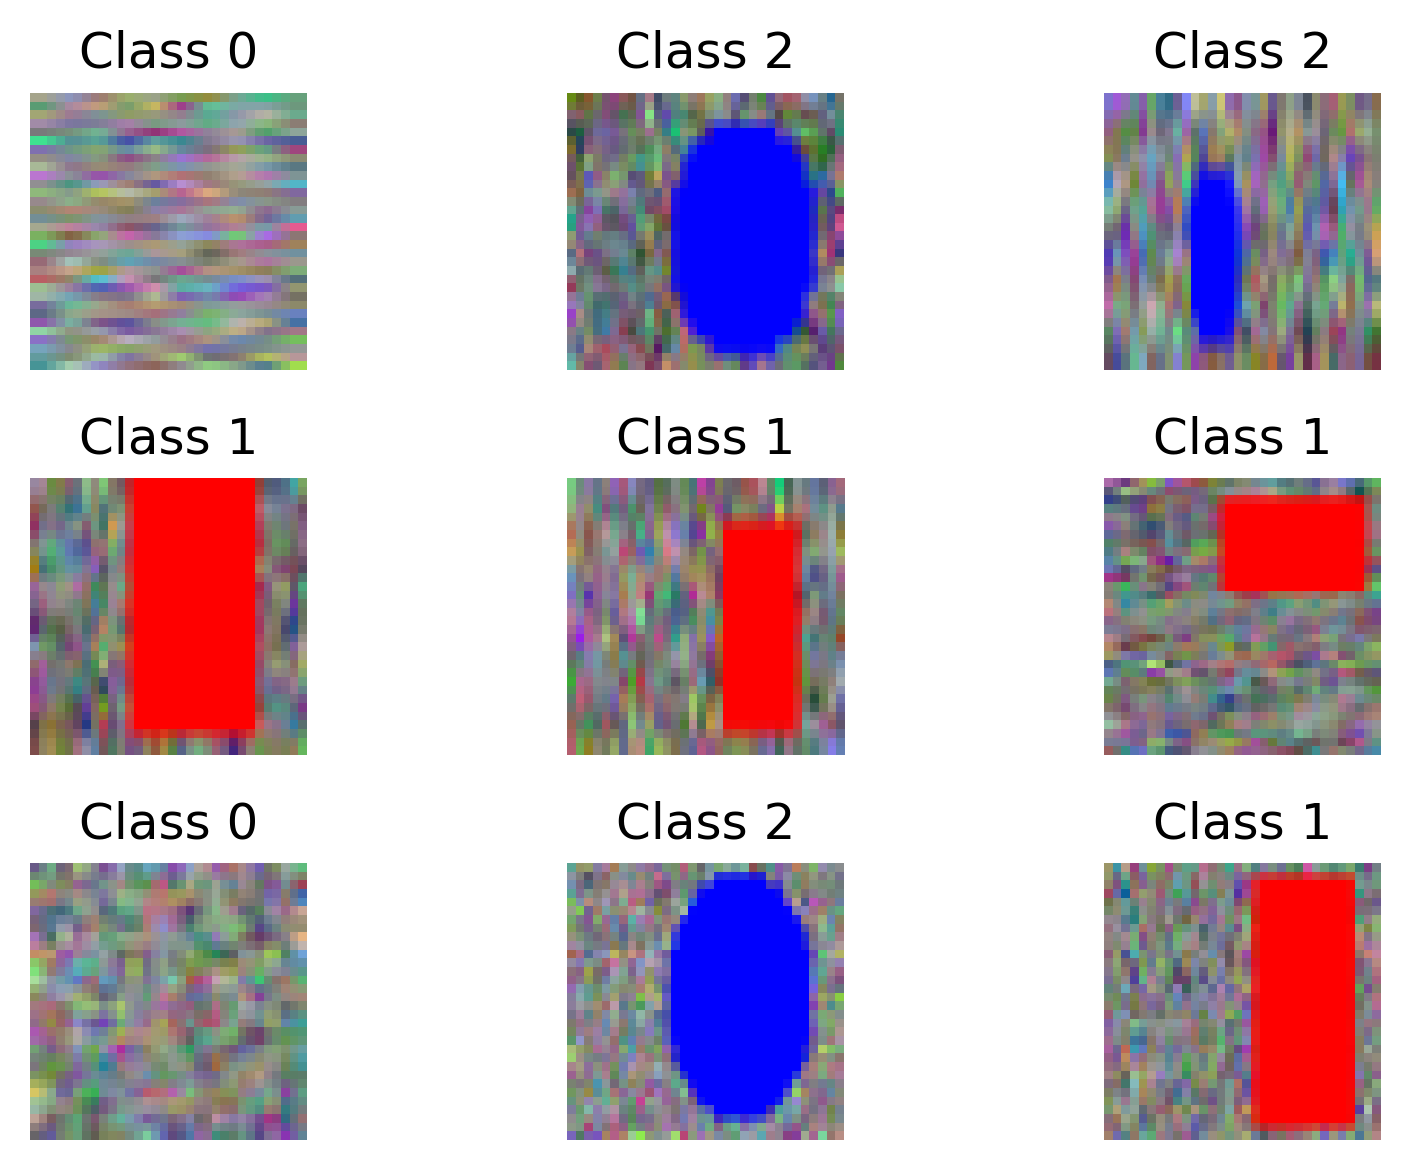

In [4]:
n = 100

image_set = np.zeros(shape=(3*n, ) + size + (3, ))
image_labels = np.zeros(3*n).astype('int')

for i in range(100):
    image_set[i] = tf.image.resize(generate_background(), size)
    image_labels[i] = 0
    image_set[n + i] = tf.image.resize(generate_square(), size)
    image_labels[n + i] = 1
    image_set[2*n + i] = tf.image.resize(generate_circle(), size)
    image_labels[2*n + i] = 2

idx = np.random.choice(np.arange(3*n), 3*n)

image_set = image_set[idx]
image_labels = image_labels[idx]

fig, axes = plt.subplots(3, 3)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(image_set[i]); ax.axis('off')
    ax.set_title(f'Class {image_labels[i]}')

fig.tight_layout()

## Step 3
Next we define a CNN to fit to the training set we just created. To make things simple, we train the network for a predetermined number of epochs, avoiding using early stopping, regularization or data augmentation.

In [5]:
epochs = 10

# construct tf.Graph
inputs = tf.keras.layers.Input(shape=size + (3, ))
x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

# define model
model = tf.keras.Model(inputs, outputs)

# compile model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy())

# fit model
model.fit(image_set, image_labels, epochs=epochs)

2022-05-10 13:42:03.921518: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-10 13:42:04.091109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10
10/10 [==============================] - 3s 41ms/step - loss: 1.0794
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 1.0241
Epoch 3/10
10/10 [==============================] - 0s 7ms/step - loss: 0.9287
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 0.7519
Epoch 5/10
10/10 [==============================] - 0s 7ms/step - loss: 0.5993
Epoch 6/10
10/10 [==============================] - 0s 7ms/step - loss: 0.4852
Epoch 7/10
10/10 [==============================] - 0s 7ms/step - loss: 0.3867
Epoch 8/10
10/10 [==============================] - 0s 7ms/step - loss: 0.2933
Epoch 9/10
10/10 [==============================] - 0s 7ms/step - loss: 0.2258
Epoch 10/10
10/10 [==============================] - 0s 7ms/step - loss: 0.1593


To validate our model, we construct a test set of the same size as the training set to test for the classification accuracy.

In [6]:
test_images = np.zeros(shape=(3*n, ) + size + (3, ))
test_labels = np.zeros(3*n).astype('int')

for i in range(100):
    test_images[i] = tf.image.resize(generate_background(), size)
    test_labels[i] = 0
    test_images[n + i] = tf.image.resize(generate_square(), size)
    test_labels[n + i] = 1
    test_images[2*n + i] = tf.image.resize(generate_circle(), size)
    test_labels[2*n + i] = 2

idx = np.random.choice(np.arange(3*n), 3*n)

test_images = test_images[idx]
test_labels = test_labels[idx]

# print accuracy on test data
print(f'Accuracy: {(np.sum(tf.argmax(model.predict(test_images), axis=1) == test_labels))/(3*n)}')

Accuracy: 0.9866666666666667


2022-05-10 13:44:09.625451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## Step 4

Now we have a neural network that is able to adequately discriminate between our classes. Next we need to create an example image containing several objects from the three different classes where the bounding boxes for the individual objects is known.





(71, 29) (85, 43)
(79, 76) (87, 84)
(101, 47) (111, 57)
(115, 20) (123, 28)
(48, 7) (58, 17)
(28, 74) (38, 84)
(116, 64) (126, 74)
(77, 3) (87, 13)
(106, 23) (115, 32)
(91, 26) (99, 34)
(103, 84) (107, 88)
(4, 46) (10, 52)
(55, 115) (64, 124)
(115, 76) (125, 86)
(3, 111) (7, 115)
(102, 13) (107, 18)


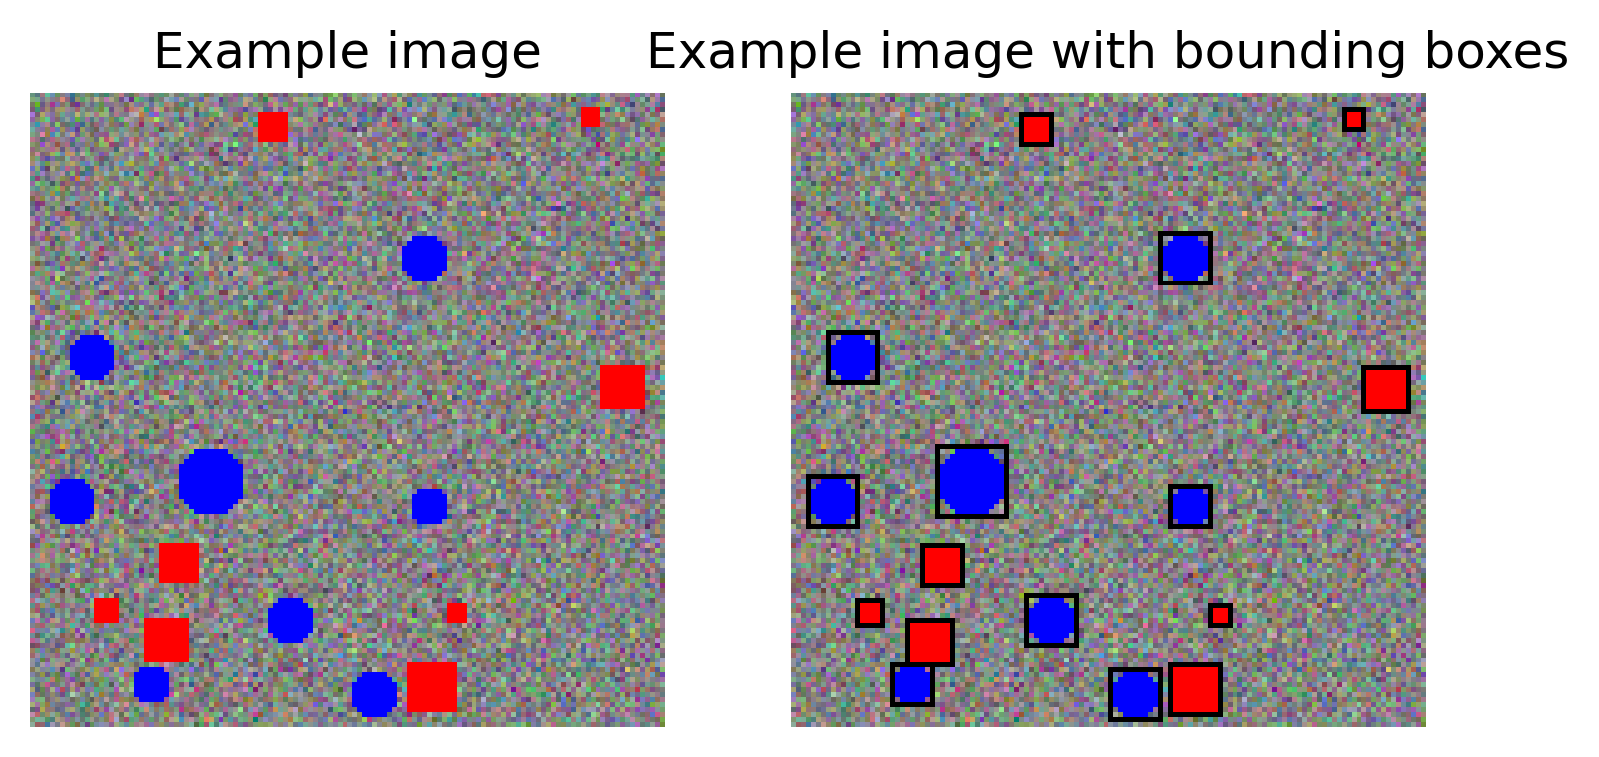

In [8]:


image = SampleImage(size=(128, 128), num_circles=8, num_squares=8)
test = image.copy()

for key in image.objects.keys():
    for upper, lower in image.objects[key]:
        rectangle(image, lower[::-1], upper[::-1], (0, 0, 0), 1)


fig, axes = plt.subplots(1, 2)

axes[0].imshow(test); axes[0].axis('off'); axes[0].set_title('Example image')
axes[1].imshow(image); axes[1].axis('off'); axes[1].set_title('Example image with bounding boxes')
plt.show()

## Step 5: Extract region proposals from an image containing several objects

In [ ]:
# next step: create tight bounding boxes around region proposals

# tile bounding box proposals
dense_proposals = felzenszwalb(image.pixels)
num_proposals = len(np.unique(dense_proposals)) - 1
proposals = np.zeros(shape=image.shape + (num_proposals, ))

for i in range(num_proposals):
    proposals[:, :, i] = dense_proposals == i + 1

proposals.shape
# match tiled array with constant array of same size
# for all proposals, compute IOU to all true class regions and label them to class if IOU is over 50

#test = np.ones(shape=(3, 4, 5))
#print(test == np.ones_like(test)*0)

In [ ]:

# construct an example image with circles and squares
image = SampleImage((128, 128), 10, 10)

# display example image along with proposed regions
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(image, cmap='gray')
ax2.imshow(mark_boundaries(image, felzenszwalb(image, scale=1)))
ax1.axis('off')
ax2.axis('off')
plt.show()

## Step 6

3 compare each region proposal with the ground truth. If IOU > 0.5 the region proposal is positive for that class. If IoU is < 0.3 for all ground truth bounding boxes, the region is positive for background.

## Step 7

4 Extract features from the proposals using the previously trained network, and use the feature vectors as input to an SVM for each class.

## Step 8
5 Bounding box regression and non-max suppression